In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
from numpy import mean, min, max
import matplotlib.dates as mdates
from datetime import datetime
from dateutil.relativedelta import relativedelta

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, and_

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
base = automap_base()

# reflect the tables
base.prepare(engine, reflect = True)

In [6]:
# View all of the classes that automap found
base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = base.classes.measurement
Station = base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)


In [9]:
# Display the Measurement row's columns and data in dictionary format
first_row = session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7fda7c13b640>,
 'id': 1,
 'date': '2010-01-01',
 'tobs': 65.0,
 'prcp': 0.08,
 'station': 'USC00519397'}

In [10]:
# Display the Station row's columns and data in dictionary format
first_row = session.query(Station).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7fda7c1afb80>,
 'latitude': 21.2716,
 'id': 1,
 'elevation': 3.0,
 'longitude': -157.8168,
 'station': 'USC00519397',
 'name': 'WAIKIKI 717.2, HI US'}

# Exploratory Precipitation Analysis

In [11]:
# Find the most recent date in the data set.
most_recent = session.query(Measurement).order_by(Measurement.date.desc()).first()
newest_date = most_recent.date
print(newest_date)

2017-08-23


In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.

dt_new_date = datetime.strptime(newest_date, '%Y-%m-%d').date()

one_year_ago = dt_new_date - relativedelta(years = 1)

# Perform a query to retrieve the data and precipitation scores
latest_year = session.query(Measurement.date,Measurement.prcp).\
filter(Measurement.date>=one_year_ago).all()

In [13]:
# Save the query results as a Pandas DataFrame and set the index to the date column
latest_df = pd.DataFrame(latest_year,
                             columns = ["Date",
                                       "Precipitation"])


In [14]:
# Sort the dataframe by date
latest_df = latest_df.sort_values("Date")

In [15]:
# Set the date to be the index
latest_df.set_index("Date")

,Precipitation
Date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15
...,...
2017-08-22,0.00
2017-08-23,0.00
2017-08-23,0.00


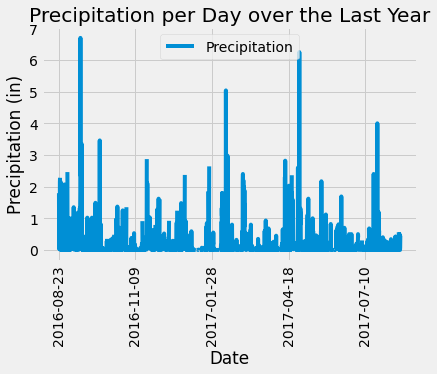

In [16]:
# Use Pandas Plotting with Matplotlib to plot the data

ax = latest_df.plot(x = "Date", y = "Precipitation")
plt.xticks(rotation = 90)
plt.title("Precipitation per Day over the Last Year")
plt.ylabel("Precipitation (in)")
plt.show()

In [17]:
# Use Pandas to calculate the summary statistics for the precipitation data
latest_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [18]:
# Design a query to calculate the total number stations in the dataset
no_of_stations = session.query(Measurement).group_by(Measurement.station).count()
print(f"There are {no_of_stations} stations used for this data set between {one_year_ago} and {newest_date}")

There are 9 stations used for this data set between 2016-08-23 and 2017-08-23


In [19]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
station_counts = session.query(Measurement.station,func.count(Measurement.station))\
.group_by(Measurement.station).order_by(func.count(Measurement.station).desc())
for row in station_counts:
    print(row)


('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [20]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active = session.query(Measurement.station)\
.group_by(Measurement.station).order_by(func.count(Measurement.station)\
.desc())
busiest_station = most_active[0][0]

In [21]:
# Query for temperature data at the busiest station
temp = session.query(Measurement.tobs).\
    filter(Measurement.station.like(busiest_station)).all()

In [22]:
# Create a list from the query of all the temperature data
temp_list = []
for row in temp:
    temp_list.append(row[0])

In [23]:
# Calculate the mean, min, and max then print them in the next cell
mean_temp = mean(temp_list)
min_temp = min(temp_list)
max_temp = max(temp_list)

In [24]:
print(f'The average temp for station {busiest_station} is {round(mean_temp, 2)} degrees F, the minimum temperature is {round(min_temp, 2)}, and the maximum temperature is {round(max_temp, 2)}')

The average temp for station USC00519281 is 71.66 degrees F, the minimum temperature is 54.0, and the maximum temperature is 85.0


In [25]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
busiest_station_data = session.query(Measurement.date,Measurement.tobs).\
filter(and_(Measurement.date>=one_year_ago,\
       Measurement.station.like(busiest_station))).all()


In [26]:
# Create dataframe from the prior query
usy_df = pd.DataFrame.from_records(busiest_station_data,
                                     index = 'Date',
                                     columns = ["Date",
                                               "Temp Observation"])
busy_df.head()

,Temp Observation
Date,
2016-08-23,77.0
2016-08-24,77.0
2016-08-25,80.0
2016-08-26,80.0
2016-08-27,75.0


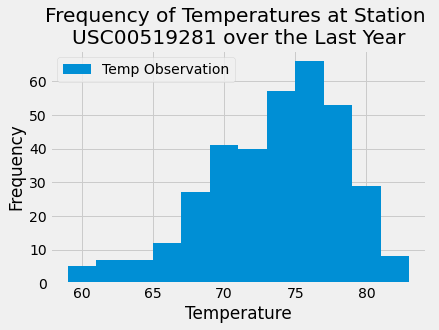

In [27]:
# plot as histogram
busy_df.plot(kind = 'hist', bins = 12)
plt.title(f"""Frequency of Temperatures at Station 
{busiest_station} over the Last Year""")
plt.xlabel("Temperature")
plt.show()

# Close session

In [28]:
# Close Session
session.close()